In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import jax_cosmo as jc
import jaxopt as jop
import halox
from halox import lss

import colossus.halo.concentration as ccon
from colossus.lss import peaks
import colossus.cosmology.cosmology as cc

# test grid
M = 1e15
z = 0.0

import jax_cosmo as jc
import colossus.cosmology.cosmology as cc

params = dict(
    Omega_c=0.2589,
    Omega_b=0.0486,
    h=0.6774,
    sigma8=0.8159,
    n_s=0.9667,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
)

hcosmo = jc.Cosmology(**params)

ccosmo = cc.setCosmology('mycosmo', {
    'Om0': params['Omega_c'] + params['Omega_b'],
    'Ob0': params['Omega_b'],
    'H0': params['h'] * 100,
    'sigma8': params['sigma8'],
    'ns': params['n_s'],
    'flat': True,
})

# hcosmo = halox.cosmology.Planck18()
# ccosmo = cc.setCosmology("planck18")

# --- Compute pieces separately ---

# Halox pieces
nu_h = lss.peak_height(M, z, hcosmo)
a_h = 1/(1+z)
x_h = (hcosmo.Omega_de / hcosmo.Omega_m)**(1/3) * a_h

# Colossus pieces
nu_c = peaks.peakHeight(M, z)
a_c = 1/(1+z)
x_c = (ccosmo.Ode0 / ccosmo.Om0)**(1/3) * a_c

print("Dark Energy difference", hcosmo.Omega_de-ccosmo.Ode0)
print("Matter difference", hcosmo.Omega_m-ccosmo.Om0)
print("nu difference:", float((nu_h - nu_c)/nu_c))
print("x difference:", float((x_h - x_c)/x_c))

# isolate concentration formula only
def formula(nu, x):
    def cmin(x):
        return 3.681 + (5.033 - 3.681) * (1.0 / np.pi * np.arctan(6.948 * (x - 0.424)) + 0.5)
    def smin(x):
        return 1.047 + (1.646 - 1.047) * (1.0 / np.pi * np.arctan(7.386 * (x - 0.526)) + 0.5)
    B0 = cmin(x) / cmin(1.393)
    B1 = smin(x) / smin(1.393)
    temp_sig = 1.686 / nu
    temp_sigp = temp_sig * B1
    temp_C = 2.881 * ((temp_sigp / 1.257) ** 1.022 + 1) * np.exp(0.06 / temp_sigp ** 2)
    return B0 * temp_C

c_h_formula_only = formula(nu_c, x_h)   # use colossus nu

c_c = ccon.modelPrada12(M, z)

print("prop-formula diff:", (c_h_formula_only - c_c)/c_c)
print(f"halox:{c_h_formula_only}, colossus:{c_c}")

/Users/lamoreau/halox/.venv/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


Dark Energy difference 9.117075465281399e-05
Matter difference 0.0
nu difference: -0.0007241124746489609
x difference: 4.388869193750369e-05
prop-formula diff: 7.182970893263573e-07
halox:5.030932797545922, colossus:5.030929183844132


In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax_cosmo as jc

from halox.halo.cMrelation import (
    duffy08,
    prada12,
    klypin11,
    child18all,
    child18relaxed,
)

p18 = halox.cosmology.Planck18()

mray = jnp.logspace(11, 15, 20)
zray =jnp.linspace(0,2.25,9)

In [ ]:

cduffy, cprada, ccall, ccrel = [] ,[], [], []
cklypin = klypin11()(M=mray)
for i in range(len(zray)):
    cduffy.append(duffy08()(mray, zray[i]))
    cprada.append(prada12()(mray, zray[i], cosmo=p18))
    ccall.append(child18all()(mray, zray[i], cosmo=p18))
    ccrel.append(child18relaxed()(mray, zray[i], cosmo=p18))
    
print(cduffy)


#fig, axs = plt.subplots(nrows = len(zray), ncols = len())



[Array([7.34383022, 7.05080035, 6.76946281, 6.49935107, 6.24001719,
       5.99103112, 5.75197997, 5.52246732, 5.30211257, 5.0905503 ,
       4.88742969, 4.69241389, 4.50517952, 4.32541609, 4.15282548,
       3.9871215 , 3.82802935, 3.67528523, 3.52863582, 3.38783794],      dtype=float64), Array([6.53634106, 6.27553122, 6.02512809, 5.78471642, 5.55389753,
       5.33228867, 5.11952233, 4.91524569, 4.71912   , 4.53082001,
       4.35003348, 4.17646061, 4.00981355, 3.84981596, 3.69620251,
       3.54871847, 3.40711927, 3.27117009, 3.14064548, 3.015329  ],      dtype=float64), Array([5.95425206, 5.71666845, 5.48856478, 5.26956279, 5.05929931,
       4.85742566, 4.66360708, 4.47752214, 4.29886227, 4.1273312 ,
       3.96264448, 3.80452901, 3.65272258, 3.50697346, 3.36703994,
       3.23268998, 3.10370079, 2.97985846, 2.86095763, 2.74680112],      dtype=float64), Array([5.50861819, 5.28881604, 5.07778433, 4.8751731 , 4.68064636,
       4.49388153, 4.3145689 , 4.14241112, 3.97712268, 3.81842

In [5]:
def vectorize_model(model, use_cosmo=False):
    if use_cosmo:
        return jax.vmap(lambda z: model(mray, z, cosmo=p18))(zray)
    else:
        return jax.vmap(lambda z: model(mray, z))(zray)
cklypin = klypin11()(M=mray)
cduffy = vectorize_model(duffy08())
cprada = vectorize_model(prada12(), use_cosmo=True)
ccall  = vectorize_model(child18all(), use_cosmo=True)
ccrel  = vectorize_model(child18relaxed(p18), use_cosmo=False)

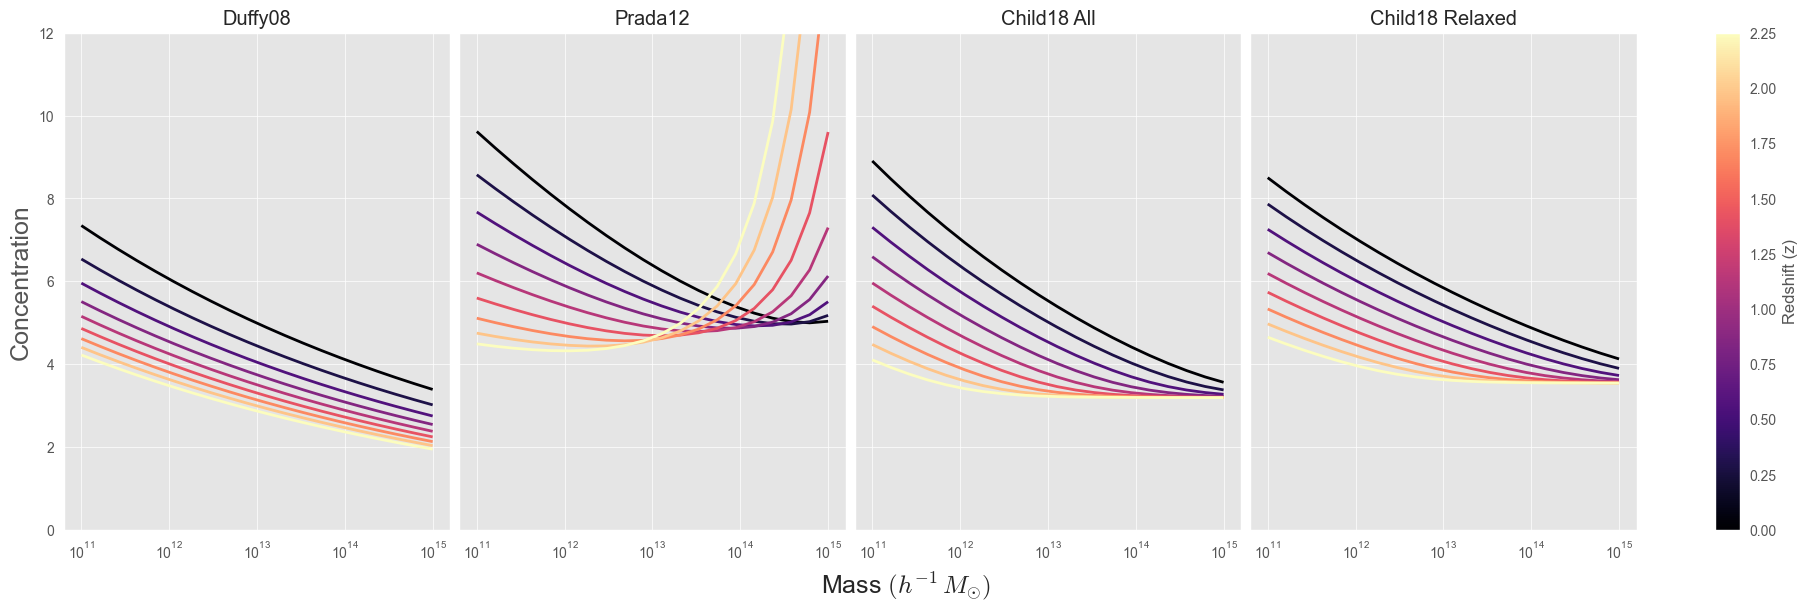

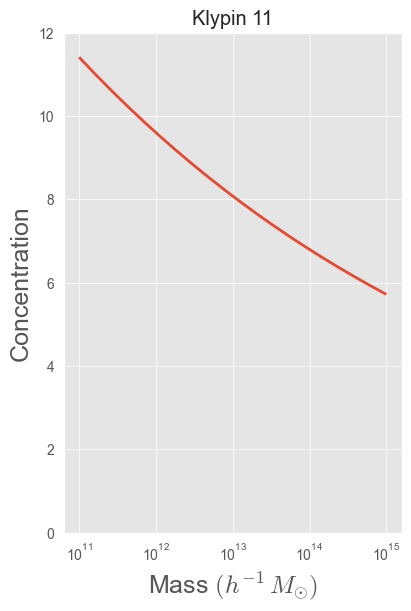

In [45]:
from matplotlib.pylab import magma
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.style.use("ggplot")

models = [
    ("Duffy08", cduffy),
    ("Prada12", cprada),
    ("Child18 All", ccall),
    ("Child18 Relaxed", ccrel),
]

fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharex=True, sharey=True, constrained_layout=True)

norm = mcolors.Normalize(vmin=zray.min(), vmax=zray.max())
cmap = cm.magma

for ax, (name, cvals) in zip(axes, models):
    
    for i, z in enumerate(zray):
        color = cmap(norm(z))
        ax.plot(
            mray,
            cvals[i],
            color = color
        )
    
    ax.set_xscale("log")
    ax.set_title(name)
    ax.set_ylim(0,12)

axes[0].set_ylabel("Concentration", fontsize = 18)
fig.supxlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize = 18)
# Shared colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes.ravel().tolist())
cbar.set_label("Redshift (z)")

plt.show()

plt.figure(figsize=(4,6), constrained_layout = True)
plt.plot(mray, cklypin)
plt.ylim(0,12)
plt.xscale("log")
plt.title("Klypin 11")
plt.ylabel("Concentration", fontsize = 18)
plt.xlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize = 18)

plt.show()


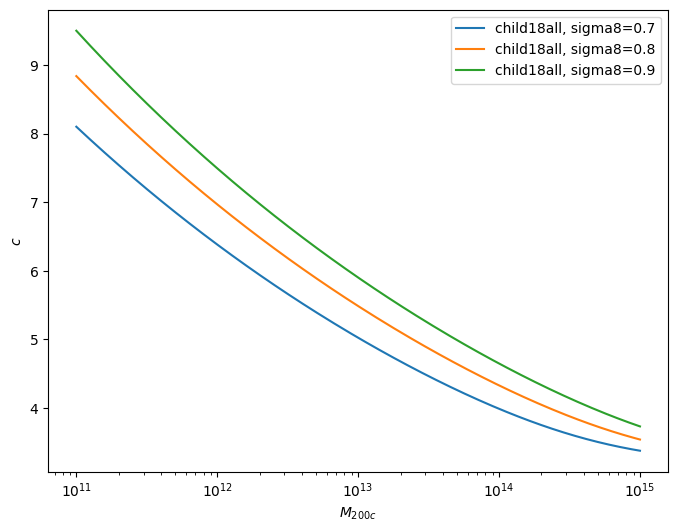

In [ ]:
sigma8_vals = [0.7, 0.8, 0.9]

fig, ax = plt.subplots(figsize=(8,6))

for s8 in sigma8_vals:
    
    cosmo_var = jc.Cosmology(
        Omega_c=0.25,
        Omega_b=0.05,
        h=0.7,
        n_s=0.97,
        sigma8=s8,
        Omega_k=0.0,
        w0=-1.0,
        wa=0.0,
    )
    
    c = child18all()(M, 0.0, cosmo_var)
    
    ax.plot(M, c, label=f"child18all, sigma8={s8}")

ax.set_xscale("log")
ax.set_xlabel(r"$M_{200c}$")
ax.set_ylabel(r"$c$")
ax.legend()
plt.show()
